### Used for doing some experiment on audio data augmentation


Load library

In [1]:
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter, TimeMask, TimeStretch

observe audio function

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import IPython.display as ipd
import noisereduce as nr

# Audio params
SAMPLE_RATE = 22050  # (samples/sec)
DURATION = 5.0  # duration in second (sec)
AUDIO_LEN = int(SAMPLE_RATE * DURATION)  # total number of samples in DURATION

# Spectrogram params
N_MELS = 128  # freq axis, number of filters
N_FFT = 2048  # frame size
HOP_LEN = 512  # non-overlap region, which means 1/4 portion overlapping
SPEC_WIDTH = AUDIO_LEN // HOP_LEN + 1  # time axis
FMAX = SAMPLE_RATE // 2  # max frequency, based on the rule, it should be half of SAMPLE_RATE
SPEC_SHAPE = [N_MELS, SPEC_WIDTH]  # expected output spectrogram shape

def load_audio(filepath, sr=SAMPLE_RATE):  # load the audio
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr

def plot_audio(audio, sr=SAMPLE_RATE):  # Plot in time domain
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def get_spectrum(audio, sr=SAMPLE_RATE):  # Plot in frequency domain
    sp = np.fft.fft(audio)
    ampSP = np.abs(sp)
    
    # Calculate the frequency axis
    freq_axis = np.fft.fftfreq(len(sp), 1 / sr)
    
    # the magnitude spectrum
    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis[:len(freq_axis)//2], ampSP[:len(freq_axis)//2])  # Only plot the positive frequencies
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Magnitude Spectrum')
    plt.grid(True)
    plt.show()

def listen_audio(audio, sr=SAMPLE_RATE):  # Listen to audio file
    ipd.display(ipd.Audio(audio, rate=sr))

def get_mel_spectrogram(audio, sr=SAMPLE_RATE):  # Get the mel-spectrogram
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)  # Turn into log-scale
    return spec

def plot_mel_spectrogram(spec, sr=SAMPLE_RATE):  # Plot the mel-spectrogram
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
    return fig

def plot_all(audio): 
    print('# Listen')
    listen_audio(audio)

    print("# Plot\n")
    # plt.figure(figsize=(18, 5))

    # plt.subplot(121)
    plot_audio(audio)
    # plt.title("Waveform",fontsize=17)

    # plt.subplot(122)
    get_spectrum(audio)
    # plt.xlabel('Frequency (Hz)')
    # plt./ylabel('Magnitude')
    # plt.title('Magnitude Spectrum')
    # plt.g/rid(True)
    # plt.show()

    # plt.figure(figsize=(12, 5))
    spec = get_mel_spectrogram(audio) 
    
    plot_mel_spectrogram(spec)
    plt.title("Spectrogram",fontsize=17)
    plt.show()

# Data preprocessing
# Use threshold to delete the low-volume data
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate / 10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

# Min-Max normalize
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))

def denoise(audio, sr=SAMPLE_RATE):
    reduced_noise = nr.reduce_noise(y=audio, sr=sr, stationary=True, prop_decrease=0.95, n_fft=N_FFT)
    return reduced_noise

c:\Users\User\anaconda3\envs\g_project_env2_audio_aug\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


observe original audio

# Listen


# Plot



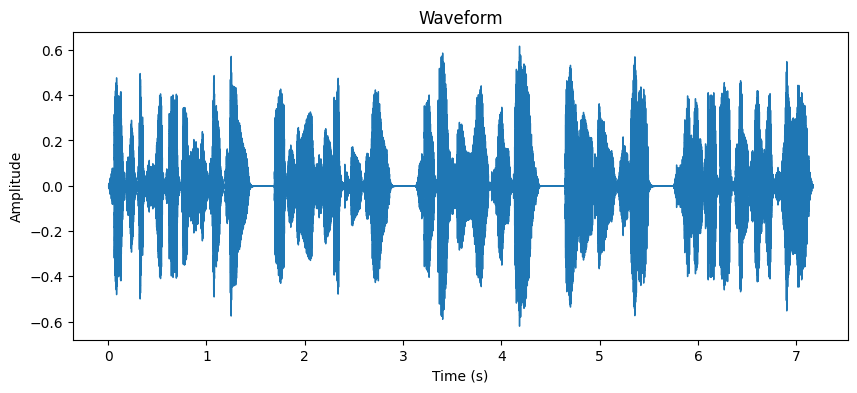

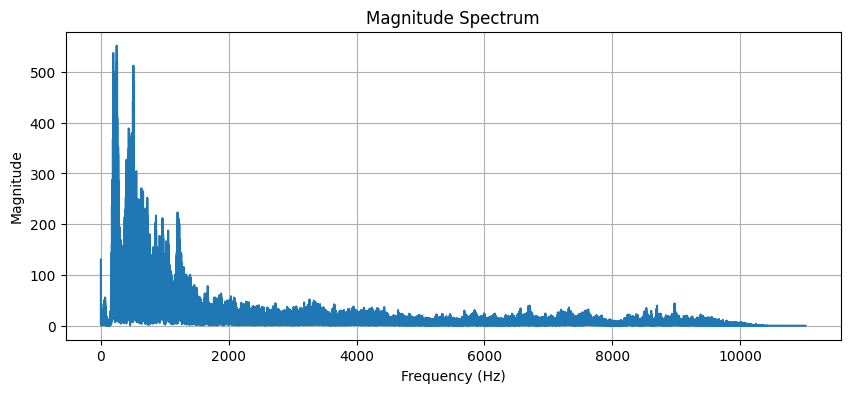

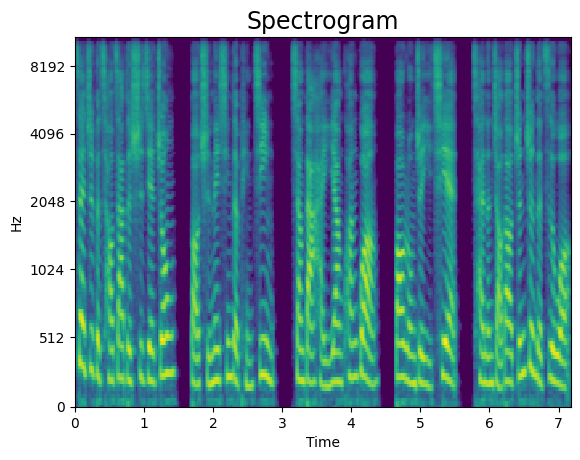

In [3]:
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
plot_all(audio)

### 1. Add loudness

paper中指的**0.6–1.4% of loudness**

In [4]:
def calculate_snr_from_loudness_percentage(noise_percentage):
    # Convert percentage to amplitude ratio
    # 這一步將噪音百分比轉換為振幅比。噪音百分比是相對於信號的振幅的，因此需要將百分比轉換為振幅比，以便進行後續的計算。
    amplitude_ratio = noise_percentage / 100.0
    
    # Convert amplitude ratio to power ratio (squared)
    # 在信號處理中，功率 P與振幅 A的平方成正比。因此，將振幅比平方就得到了噪音相對於信號的功率比。P=A^2
    power_ratio = amplitude_ratio ** 2
    
    # Calculate SNR in decibels
    snr = 10 * np.log10(1 / power_ratio)  # 1 for signal power, power_ratio for noise power
    
    return snr

# Example loudness percentages
loudness_percentage_min = 0.6
loudness_percentage_max = 1.4

# Calculate SNR for given loudness percentages
snr_min = calculate_snr_from_loudness_percentage(loudness_percentage_min)
snr_max = calculate_snr_from_loudness_percentage(loudness_percentage_max)

print(f"SNR (for {loudness_percentage_min}% noise): {snr_min:.2f} dB")
print(f"SNR (for {loudness_percentage_max}% noise): {snr_max:.2f} dB")

SNR (for 0.6% noise): 44.44 dB
SNR (for 1.4% noise): 37.08 dB


加入**較小**的Minimum noise amplification factor.
聽起來噪音較少，看圖片也是

In [5]:
augment_add_loudness = Compose(
    [
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
    ]
)

# Listen


# Plot



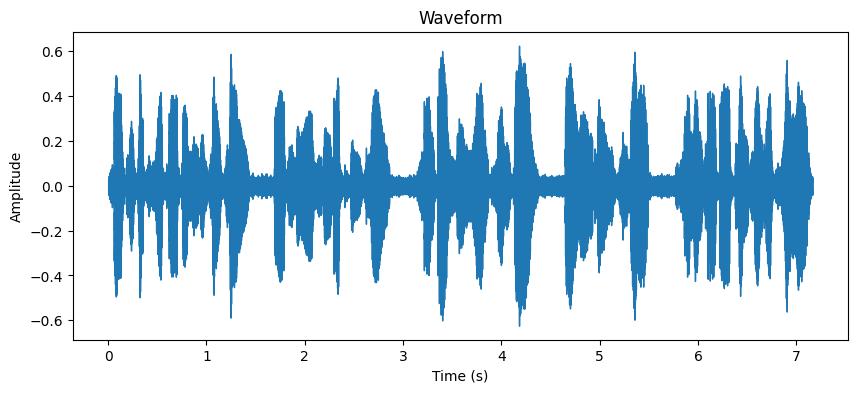

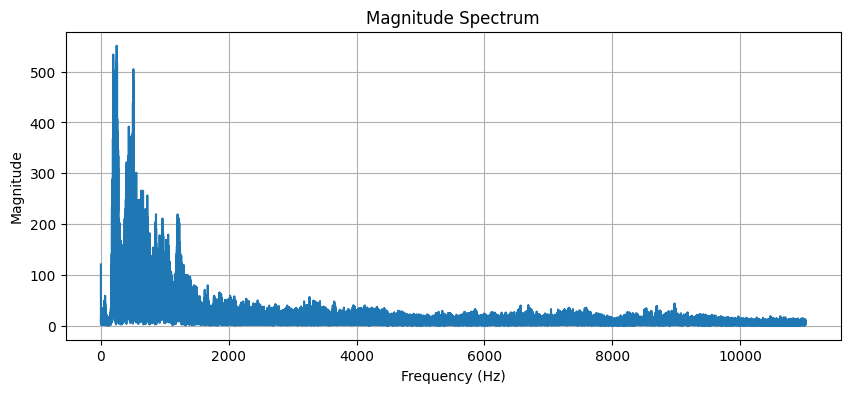

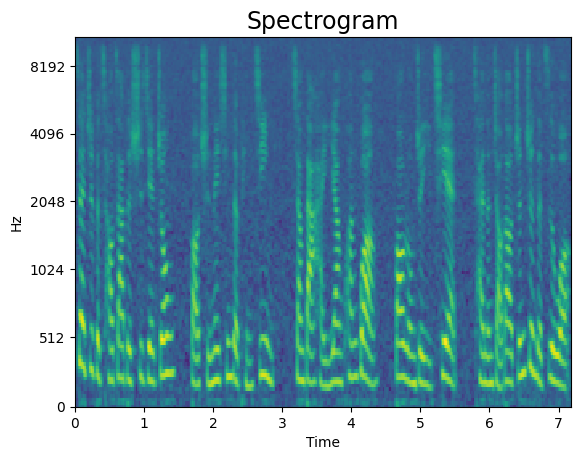

In [6]:
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
augmented_add_loudness_audio = augment_add_loudness(audio, sr)
sf.write("output_9_add_loudness.wav", augmented_add_loudness_audio, sr)
plot_all(augmented_add_loudness_audio)

In [7]:
def calculate_snr(original_signal, augmented_signal):
    # 計算噪聲
    noise = augmented_signal - original_signal
    
    # 計算信號功率（方差）
    signal_power = np.var(original_signal)
    
    # 計算噪聲功率（方差）
    noise_power = np.var(noise)
    
    # 計算 SNR（以 dB 為單位）
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

# 假設 original_signal 是原始信號，augmented_signal 是添加噪聲後的信號
snr_value = calculate_snr(audio, augmented_add_loudness_audio)
print(f"SNR: {snr_value:.2f} dB")


SNR: 16.83 dB


加入**較多**的Minimum noise amplification factor.
聽起來噪音較多，看圖片也是

In [8]:
augment_add_loudness_min01 = Compose(
    [
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=1)
    ]
)

# Listen


# Plot



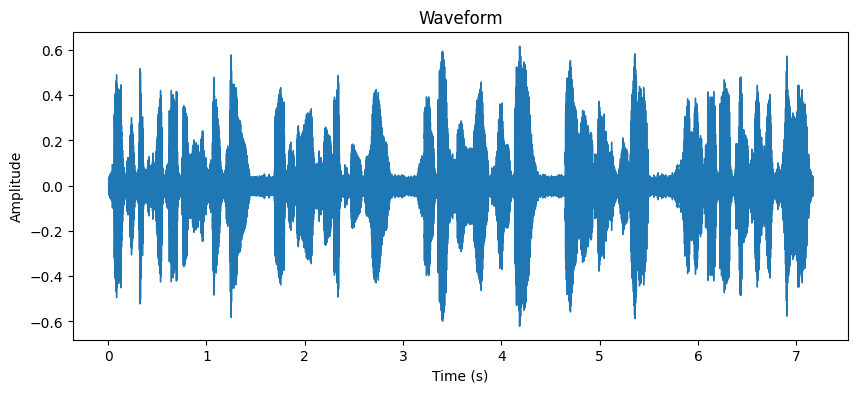

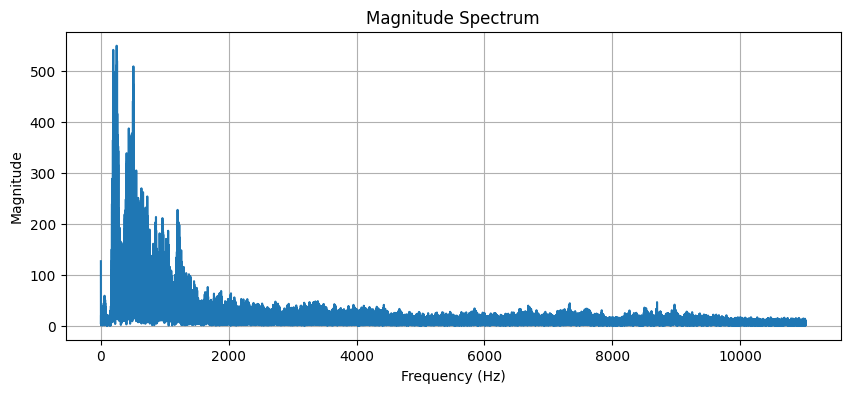

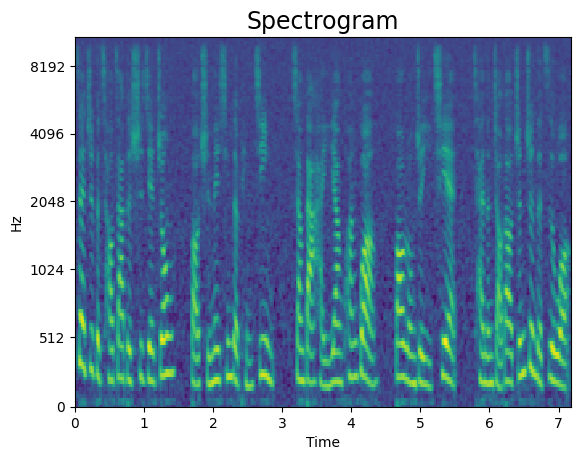

In [9]:
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
augmented_add_loudness_min01_audio = augment_add_loudness_min01(audio, sr)
# sf.write("output_9_add_loudness.wav", augmented_add_loudness_audio, sr)
plot_all(augmented_add_loudness_min01_audio)

In [10]:
# 假設 original_signal 是原始信號，augmented_signal 是添加噪聲後的信號
snr_value = calculate_snr(audio, augmented_add_loudness_min01_audio)
print(f"SNR: {snr_value:.2f} dB")


SNR: 16.81 dB


#### 固定SNR，來產生noise

In [11]:
def calculate_noise_std_from_snr(snr_db, rms_signal):
    """
    Calculate the standard deviation of noise required to achieve a given SNR in dB.

    Parameters:
    - snr_db: Signal-to-noise ratio in decibels.
    - rms_signal: RMS value of the signal.

    Returns:
    - noise_std: Standard deviation of the noise.
    """
    # Calculate the power ratio of the noise relative to the signal
    power_ratio = 10 ** (-snr_db / 10)
    
    # Calculate the standard deviation of the noise based on the power ratio
    noise_std = rms_signal * np.sqrt(power_ratio)
    
    return noise_std

def apply_noise_to_audio(audio, sr, snr_db=10):
    """
    Apply Gaussian noise to an audio signal to achieve a specific SNR.

    Parameters:
    - audio: The input audio signal.
    - sr: Sample rate of the audio.
    - snr_db: Desired signal-to-noise ratio in decibels.

    Returns:
    - augmented_audio: Audio signal with added Gaussian noise.
    """
    # Calculate the RMS value of the signal
    rms_signal = np.sqrt(np.mean(audio**2))
    
    # Calculate the required noise standard deviation for the desired SNR
    noise_std = calculate_noise_std_from_snr(snr_db, rms_signal)
    
    # Create an audio augmentation pipeline with Gaussian noise
    augment_add_loudness = Compose(
        [
            AddGaussianNoise(min_amplitude=noise_std, max_amplitude=noise_std, p=1)
        ]
    )
    
    # Apply the noise augmentation to the audio signal
    augmented_audio = augment_add_loudness(audio, sr)
    
    return augmented_audio

Application

snr_db = 35

# Listen


# Plot



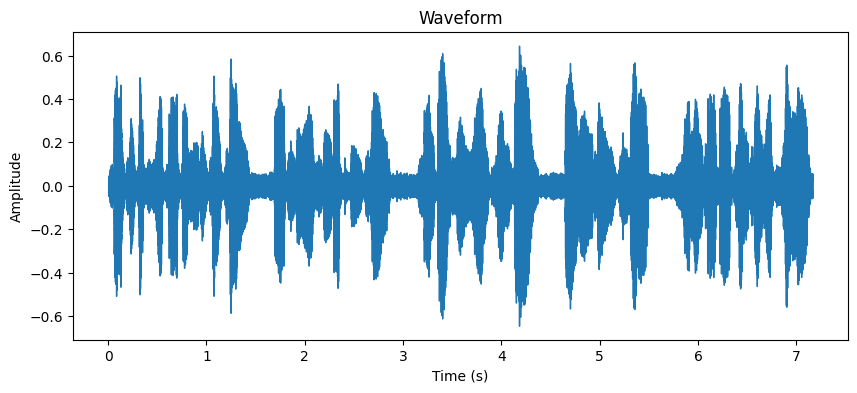

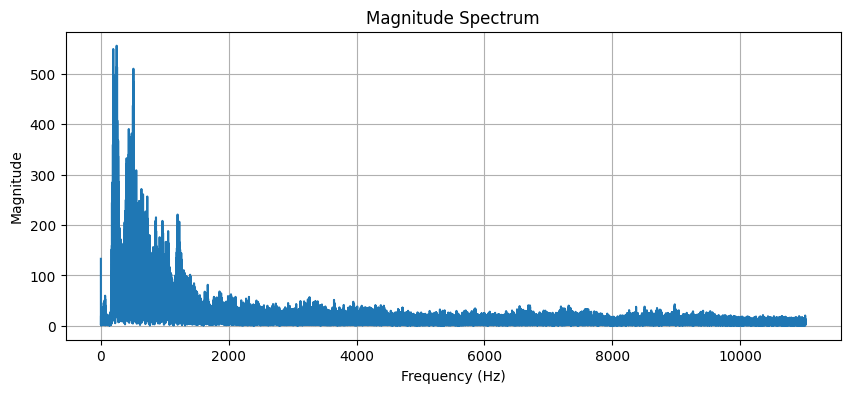

In [56]:
#  Setting SNR
snr_db = 15
# 載入音頻
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
    
# 應用噪聲增強
augmented_audio = apply_noise_to_audio(audio, sr, snr_db)
    
# 儲存處理後的音頻
# sf.write(output_path, augmented_audio, sr)
    
# 顯示音頻
plot_all(augmented_audio)

snr_db = 20

# Listen


# Plot



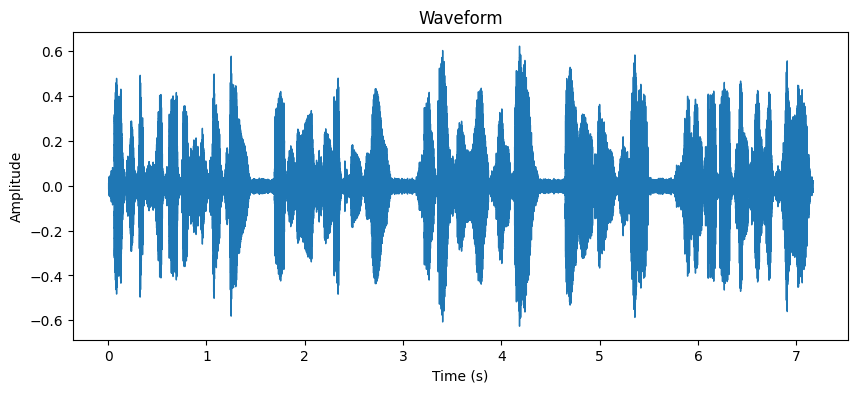

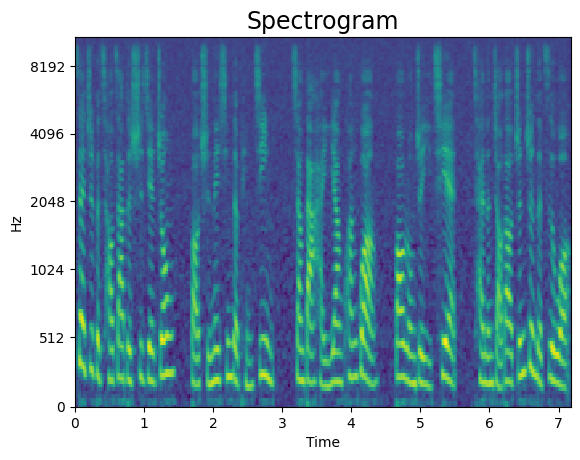

In [13]:
#  Setting SNR
snr_db = 20
# 載入音頻
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
    
# 應用噪聲增強
augmented_audio = apply_noise_to_audio(audio, sr, snr_db)
    
# 儲存處理後的音頻
# sf.write(output_path, augmented_audio, sr)
    
# 顯示音頻
plot_all(augmented_audio)

### 2. Randommly Mask

In [14]:
augment_TimeMask = Compose(
    [
        TimeMask(min_band_part=0.1, max_band_part=0.15, fade=True, p=1.0)
    ]
    # at least 10% of the audio will be masked.
    # up to 15% of the audio can be masked.
)

# Listen


# Plot



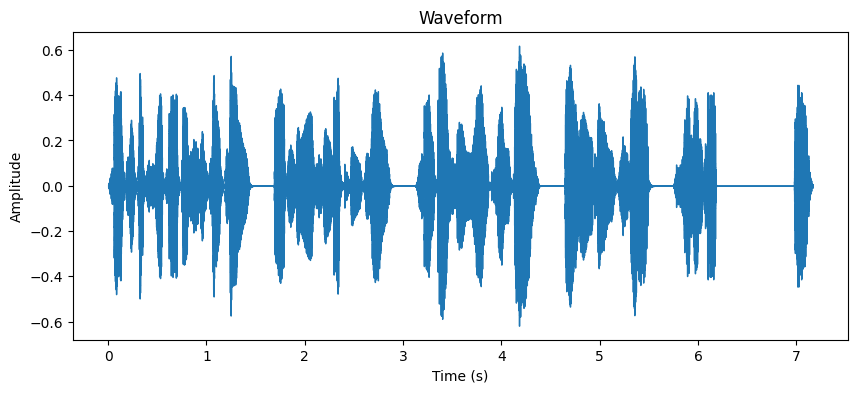

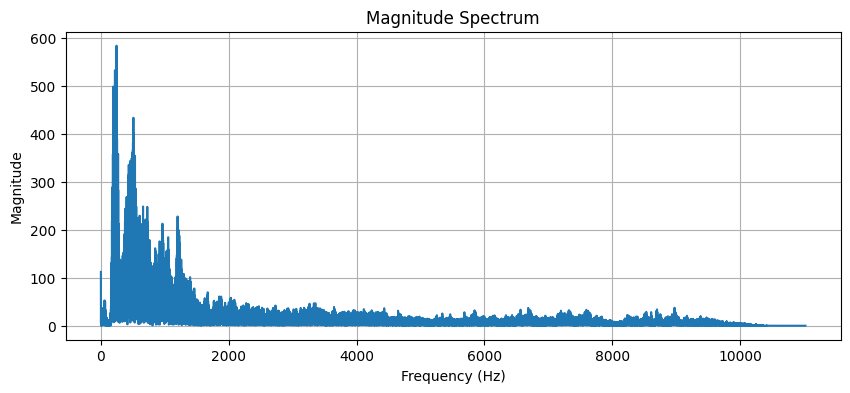

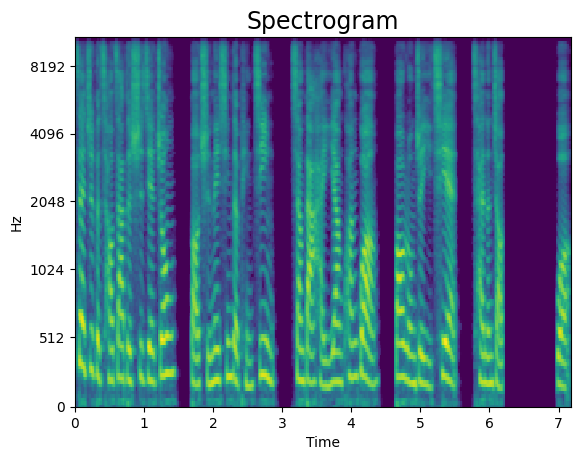

In [15]:
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
augmented_TimeMask_audio = augment_TimeMask(audio, sr)
# sf.write("output_9_add_loudness.wav", augmented_add_loudness_audio, sr)
plot_all(augmented_TimeMask_audio)

### 3. TimeStretch 改變語速

In [16]:
augment_TimeStretch = Compose(
    [
        TimeStretch(min_rate=0.8, max_rate=1.25, leave_length_unchanged=True, p=1.0)
    ]
    # Minimum rate of change of total duration of the signal. A rate below 1 means the audio is slowed down.
    # Maximum rate of change of total duration of the signal. A rate greater than 1 means the audio is speed up.
    # don't keep the length unchanged
)

# Listen


# Plot



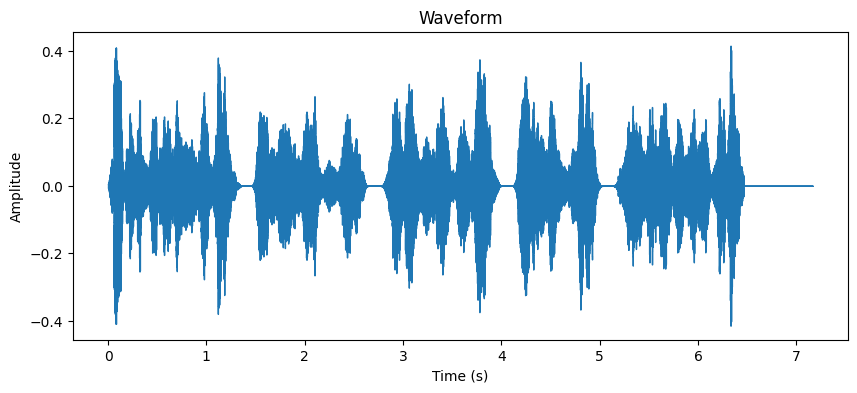

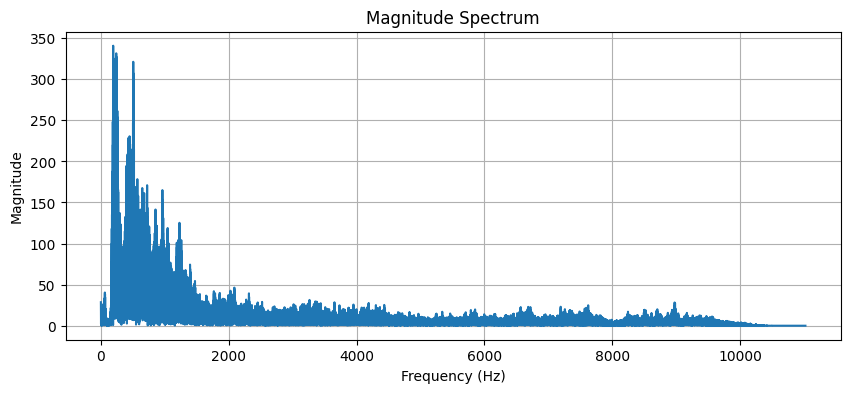

In [17]:
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
augmented_TimeStretch_audio = augment_TimeStretch(audio, sr)
# sf.write("output_9_add_loudness.wav", augmented_add_loudness_audio, sr)
plot_all(augmented_TimeStretch_audio)

* Librosa版本，其實官網上寫`TimeStretch`，其中也是來自`librosa.effects.time_stretch`

In [18]:
def manipulate(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

# Listen


# Plot



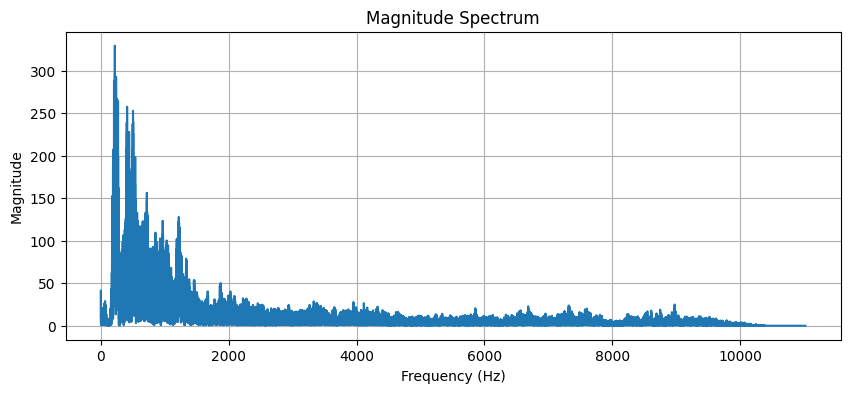

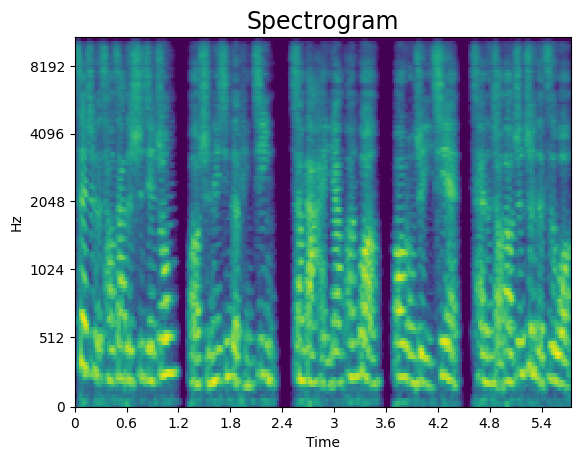

In [19]:
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
augmented_Librosa_TimeStretch = manipulate(audio, 1.25)
# sf.write("output_9_add_loudness.wav", augmented_add_loudness_audio, sr)
plot_all(augmented_Librosa_TimeStretch)

### An example of complex audio data augmentation.

In [20]:
augment = Compose(
    [
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=1),
        PitchShift(min_semitones=-8, max_semitones=8, p=1),
        HighPassFilter(min_cutoff_freq=2000, max_cutoff_freq=4000, p=1)
    ]
)
audio, sr = load_audio("t_audio_aug_output_9.wav", SAMPLE_RATE)
augmented_TimeMask_audio = augment(audio, sr)
# sf.write("output_9_add_loudness.wav", augmented_add_loudness_audio, sr)
plot_all(augmented_TimeMask_audio)

# Listen


# Plot



Test pydub  
發現要用librosa來load  
用pydub來存

22050
# Listen


# Plot



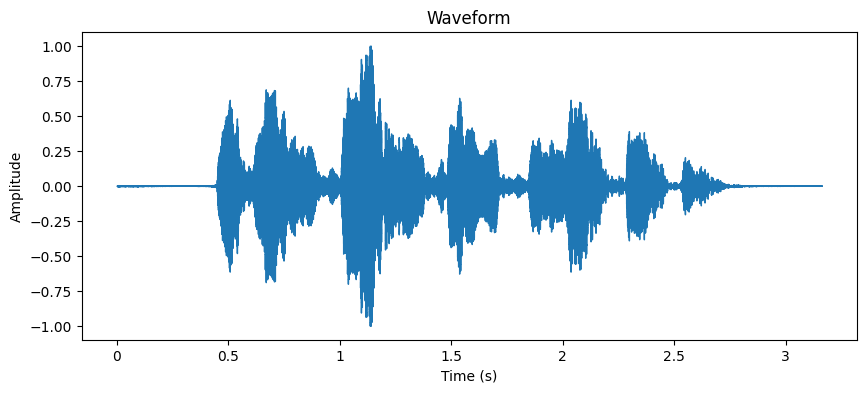

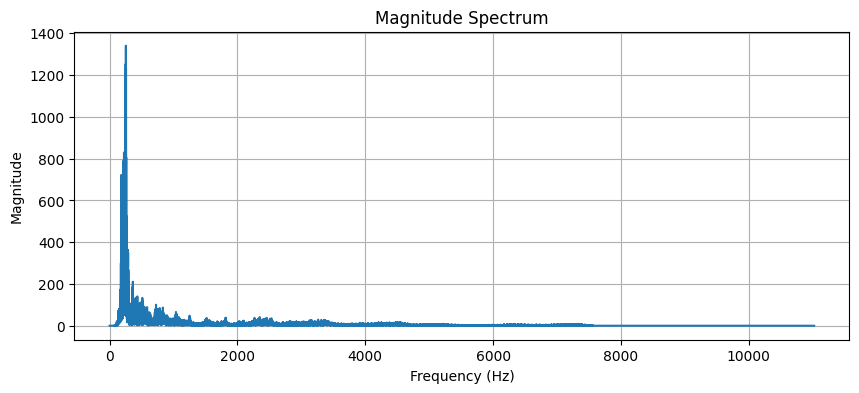

# Listen


# Plot



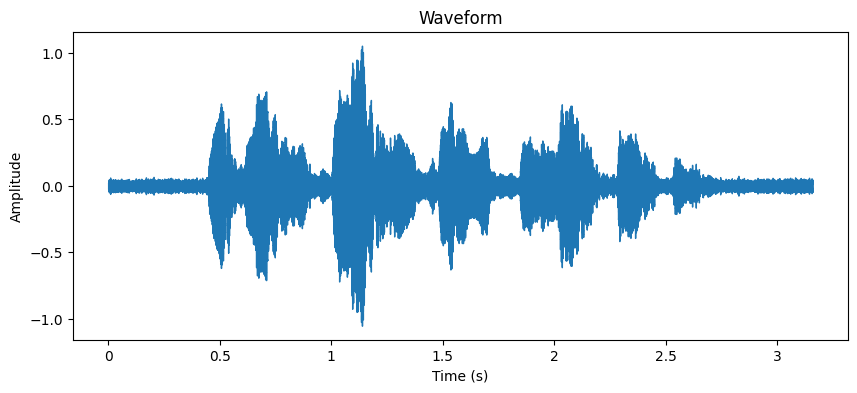

In [42]:
from pydub import AudioSegment
import os
import numpy as np
from audiomentations import Compose, AddGaussianNoise
from observe_audio_function_ver2 import SAMPLE_RATE
import librosa

def calculate_noise_std_from_snr(snr_db, rms_signal):
    """
    Calculate the standard deviation of noise required to achieve a given SNR in dB.

    Parameters:
    - snr_db: Signal-to-noise ratio in decibels.
    - rms_signal: RMS value of the signal.

    Returns:
    - noise_std: Standard deviation of the noise.
    """
    # Calculate the power ratio of the noise relative to the signal
    power_ratio = 10 ** (-snr_db / 10)
    
    # Calculate the standard deviation of the noise based on the power ratio
    noise_std = rms_signal * np.sqrt(power_ratio)
    
    return noise_std

def apply_noise_to_audio(audio, sr, snr_db=10):
    """
    Apply Gaussian noise to an audio signal to achieve a specific SNR.

    Parameters:
    - audio: The input audio signal.
    - sr: Sample rate of the audio.
    - snr_db: Desired signal-to-noise ratio in decibels.

    Returns:
    - augmented_audio: Audio signal with added Gaussian noise.
    """
    # Calculate the RMS value of the signal
    rms_signal = np.sqrt(np.mean(audio**2))
    
    # Calculate the required noise standard deviation for the desired SNR
    noise_std = calculate_noise_std_from_snr(snr_db, rms_signal)
    
    # Create an audio augmentation pipeline with Gaussian noise
    augment_add_loudness = Compose(
        [
            AddGaussianNoise(min_amplitude=noise_std, max_amplitude=noise_std, p=1)
        ]
    )
    
    # Apply the noise augmentation to the audio signal
    augmented_audio = augment_add_loudness(audio, sr)
    
    return augmented_audio

def load_audio_with_pydub(file_path, sample_rate=None):
    """
    Load audio file using pydub, ensuring compatibility with various formats, and optionally resample to a given sample rate.

    Parameters:
    - file_path: Path to the audio file.
    - sample_rate: Desired sample rate for the audio. If None, use the original sample rate.

    Returns:
    - audio: Loaded audio signal.
    - sr: Sample rate of the audio.
    """
    audio_segment = AudioSegment.from_file(file_path)
    audio = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)
    sr = audio_segment.frame_rate
    print(sr)
    if audio_segment.channels == 2:
        audio = audio.reshape((-1, 2)).mean(axis=1)  # Convert to mono if stereo

    if sample_rate and sample_rate != sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=sample_rate)
        sr = sample_rate

    return audio, sr

def save_audio_with_pydub(audio, sr, file_path):
    """
    Save audio file using pydub to preserve the original format.

    Parameters:
    - audio: Audio signal to save.
    - sr: Sample rate of the audio.
    - file_path: Path to save the audio file.
    """
    audio_segment = AudioSegment(
        audio.tobytes(),
        frame_rate=sr,
        sample_width=audio.dtype.itemsize,
        channels=1
    )
    audio_segment.export(file_path, format=file_path.split('.')[-1])
if __name__ == "__main__":
    # audio, sr = load_audio_with_pydub(r"D:\clone_audio\yang_chinesedata\fake\gl\SSB07000046_gl.wav", SAMPLE_RATE)
    audio, sr = load_audio(r"D:\clone_audio\yang_chinesedata\fake\gl\SSB07000046_gl.wav", SAMPLE_RATE)
    
    print(sr)
    plot_all(audio)

    # 應用噪聲增強
    augmented_audio = apply_noise_to_audio(audio, sr, snr_db=20)
        
    # 儲存處理後的音頻
    output_path = "tempsf.wav"
    sf.write(output_path, augmented_audio, sr)
        
    # 顯示音頻
    plot_all(augmented_audio)
    
    # save_audio_with_pydub(augmented_audio, sr, output_path)